## Global settings and imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from pathlib import Path
import polars as pl
import matplotlib.pyplot as plt
#import optuna
from tqdm import tqdm
import torch.optim as optim

from utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_IMPRESSION_ID_COL,
    DEFAULT_SUBTITLE_COL,
    DEFAULT_LABELS_COL,
    DEFAULT_TITLE_COL,
    DEFAULT_USER_COL,
    DEFAULT_ARTICLE_PUBLISHED_TIMESTAMP_COL
)

from utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    add_known_user_column,
    add_prediction_scores,
    truncate_history,
)
from evaluation import MetricEvaluator, AucScore, NdcgScore, MrrScore
from utils._articles import convert_text2encoding_with_transformers
from utils._polars import concat_str_columns, slice_join_dataframes
from utils._articles import create_article_id_to_value_mapping
from utils._nlp import get_transformers_word_embeddings, generate_embeddings_with_transformers
from utils._python import write_submission_file, rank_predictions_by_score
from models_pytorch.model_config import hparams_nrms

from models_pytorch.nrms import NRMSModel
from models_pytorch.NRMSDocVecModel import NRMSDocVecModel

from transformers import AutoTokenizer, AutoModel
from models_pytorch.dataloader import NRMSDataSet

# Check Python version
print(f"Python version: {sys.version.split()[0]}")

# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Check GPU availability
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU device: {torch.cuda.get_device_name()}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")

/Users/gustavsiphone/Documents/GitHub/Deeplearning-RecSys-Challenge-2024/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version: 3.12.5
PyTorch version: 2.5.1
CUDA available: False


## Prepare parameters

In [2]:
seed = 42
batch_size = 64

# Options: demo, small, large
MIND_type = 'demo'

## Looking at behaviours and history

## Download and load data

In [3]:
PATH = Path("./ebnerd_small")  # Base path for your data directory
print(PATH)


ebnerd_small


In [4]:
def ebnerd_from_path(path: Path, history_size: int = 30) -> pl.DataFrame:
    """
    Load ebnerd - function
    """
    df_history = (
        pl.scan_parquet(path.joinpath("history.parquet"))
        .select(DEFAULT_USER_COL, DEFAULT_HISTORY_ARTICLE_ID_COL)
        .pipe(
            truncate_history,
            column=DEFAULT_HISTORY_ARTICLE_ID_COL,
            history_size=history_size,
            padding_value=0,
            enable_warning=False,
        )
    )
    df_behaviors = (
        pl.scan_parquet(path.joinpath("behaviors.parquet"))
        .collect()
        .pipe(
            slice_join_dataframes,
            df2=df_history.collect(),
            on=DEFAULT_USER_COL,
            how="left",
        )
    )
    return df_behaviors

COLUMNS = [
    DEFAULT_USER_COL,
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_IMPRESSION_ID_COL,
]
HISTORY_SIZE = 40 # TODO: History size. 
FRACTION = 0.2

df_train = (
    ebnerd_from_path(PATH.joinpath("train"), history_size=HISTORY_SIZE)
    .select(COLUMNS)
    .pipe(
        sampling_strategy_wu2019,
        npratio=4,
        shuffle=True,
        with_replacement=True,
        seed=123,
    )
    .pipe(create_binary_labels_column)
    .sample(fraction=FRACTION)
)
# =>
df_validation = (
    ebnerd_from_path(PATH.joinpath("validation"), history_size=HISTORY_SIZE)
    .select(COLUMNS)
    .pipe(create_binary_labels_column)
    .sample(fraction=FRACTION)
)
df_train.head(2)

user_id,article_id_fixed,article_ids_inview,article_ids_clicked,impression_id,labels
u32,list[i32],list[i64],list[i64],u32,list[i8]
1192302,"[0, 0, … 9764781]","[9494434, 9755800, … 9527358]",[9773275],85979274,"[0, 0, … 0]"
1792806,"[9766468, 9763307, … 9770638]","[9778422, 9778413, … 9775703]",[9778413],174370599,"[0, 1, … 0]"


In [5]:
def calculate_average_length(df, column):
    total_length = sum(len(row) for row in df[column])
    average_length = total_length / len(df)
    return average_length

# Calculate average length for df_train
average_length_inview_train = calculate_average_length(df_train, DEFAULT_INVIEW_ARTICLES_COL)
print(f"Average length of article_ids_inview in df_train: {average_length_inview_train}")

# Calculate average length for df_validation
average_length_inview_validation = calculate_average_length(df_validation, DEFAULT_INVIEW_ARTICLES_COL)
print(f"Average length of article_ids_inview in df_validation: {average_length_inview_validation}")

Average length of article_ids_inview in df_train: 5.0
Average length of article_ids_inview in df_validation: 12.014653886243332


In [6]:
# Function to find the maximum length of arrays in a column
def find_max_length(df, column):
    max_length = 0
    for row in df[column]:
        max_length = max(max_length, len(row))
    return max_length

# Find the longest inview article length in df_train
max_inview_length_train = find_max_length(df_train, DEFAULT_INVIEW_ARTICLES_COL)

# Find the longest inview article length in df_validation
max_inview_length_validation = find_max_length(df_validation, DEFAULT_INVIEW_ARTICLES_COL)

print(f"Longest inview article length in df_train: {max_inview_length_train}")
print(f"Longest inview article length in df_validation: {max_inview_length_validation}")

max_history_length_train = find_max_length(df_train, DEFAULT_HISTORY_ARTICLE_ID_COL)
max_history_length_validation = find_max_length(df_validation, DEFAULT_HISTORY_ARTICLE_ID_COL)

print(f"Longest history length in df_train: {max_history_length_train}")
print(f"Longest history length in df_validation: {max_history_length_validation}")

Longest inview article length in df_train: 5
Longest inview article length in df_validation: 91
Longest history length in df_train: 40
Longest history length in df_validation: 40


In [7]:
# Function to filter rows with exactly one clicked article
def filter_rows_with_one_clicked_article(df, clicked_articles_col):
    # Manually filter rows where the array has exactly one element
    filtered_rows = []
    for row in df.iter_rows(named=True):
        if len(row[clicked_articles_col]) == 1:
            filtered_rows.append(row)
    return pl.DataFrame(filtered_rows)


# Filter rows in df_train and df_validation
df_train = filter_rows_with_one_clicked_article(df_train, DEFAULT_CLICKED_ARTICLES_COL)
df_validation = filter_rows_with_one_clicked_article(df_validation, DEFAULT_CLICKED_ARTICLES_COL)

# Print the results
print(f"Number of rows with exactly one clicked article in df_train: {df_train.shape[0]}")
print(f"Number of rows with exactly one clicked article in df_validation: {df_validation.shape[0]}")


Number of rows with exactly one clicked article in df_train: 46855
Number of rows with exactly one clicked article in df_validation: 48660


In [8]:
df_validation.head()

user_id,article_id_fixed,article_ids_inview,article_ids_clicked,impression_id,labels
i64,list[i64],list[i64],list[i64],i64,list[i64]
2585704,"[9772088, 9767909, … 9778302]","[9783993, 9784856, … 9784879]",[9783993],476486371,"[1, 0, … 0]"
1929780,"[9774142, 9773486, … 9777307]","[9769155, 9784044, … 9784406]",[9784662],486250838,"[0, 0, … 0]"
643200,"[9771995, 9769605, … 9778971]","[8392487, 9788400, … 9789001]",[9782845],548034706,"[0, 0, … 0]"
2004965,"[9737062, 9764822, … 9776322]","[9277339, 9782996, … 9759345]",[9781991],429985421,"[0, 0, … 0]"
1429215,"[9777005, 9778168, … 9778902]","[9779370, 9784642, … 9784444]",[9778787],270600342,"[0, 0, … 0]"


In [9]:
print(f"Number of users in df_train: {df_train['user_id'].n_unique()}")

Number of users in df_train: 11273


In [10]:
df_articles = pl.read_parquet(PATH.joinpath("articles.parquet"))
df_articles.head(10)

article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str
3001353,"""Natascha var ikke den første""","""Politiet frygter nu, at Natasc…",2023-06-29 06:20:33,false,"""Sagen om den østriske Natascha…",2006-08-31 08:06:45,[3150850],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Kriminalitet"", ""Personfarlig kriminalitet""]",140,[],"""krimi""",null,null,null,0.9955,"""Negative"""
3003065,"""Kun Star Wars tjente mere""","""Biografgængerne strømmer ind f…",2023-06-29 06:20:35,false,"""Vatikanet har opfordret til at…",2006-05-21 16:57:00,[3006712],"""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Underholdning"", ""Film og tv"", ""Økonomi""]",414,"[433, 434]","""underholdning""",null,null,null,0.846,"""Positive"""
3012771,"""Morten Bruun fyret i Sønderjys…","""FODBOLD: Morten Bruun fyret me…",2023-06-29 06:20:39,false,"""Kemien mellem spillerne i Supe…",2006-05-01 14:28:40,[3177953],"""article_default""","""https://ekstrabladet.dk/sport/…",[],[],"[""Erhverv"", ""Kendt"", … ""Ansættelsesforhold""]",142,"[196, 199]","""sport""",null,null,null,0.8241,"""Negative"""
3023463,"""Luderne flytter på landet""","""I landets tyndest befolkede om…",2023-06-29 06:20:43,false,"""Det frække erhverv rykker på l…",2007-03-24 08:27:59,[3184029],"""article_default""","""https://ekstrabladet.dk/nyhede…",[],[],"[""Livsstil"", ""Erotik""]",118,[133],"""nyheder""",null,null,null,0.7053,"""Neutral"""
3032577,"""Cybersex: Hvornår er man utro?""","""En flirtende sms til den flott…",2023-06-29 06:20:46,false,"""De fleste af os mener, at et t…",2007-01-18 10:30:37,[3030463],"""article_default""","""https://ekstrabladet.dk/sex_og…",[],[],"[""Livsstil"", ""Partnerskab""]",565,[],"""sex_og_samliv""",null,null,null,0.9307,"""Neutral"""
3033563,"""Kniven for struben-vært får se…","""I aftenens udgave af 'Med kniv…",2023-06-29 06:20:47,false,"""Når man ser fjerde program i T…",2007-03-27 10:22:08,"[3005524, 3005525]","""article_default""","""https://ekstrabladet.dk/underh…",[],[],"[""Livsstil"", ""Underholdning"", … ""Mad og drikke""]",414,"[433, 436]","""underholdning""",null,null,null,0.9371,"""Neutral"""
3034608,"""Willy Strube har begået selvmo…","""Den tidligere SiD-chef tog sit…",2023-06-29 06:20:49,false,"""Den tidligere formand for Indu…",2001-10-19 12:30:00,[3204848],"""article_default""","""https://ekstrabladet.dk/nyhede…","[""Willy Strube"", ""Willy Strube"", ""Willy Strube""]","[""PER"", ""PER"", ""PER""]","[""Kriminalitet"", ""Erhverv"", … ""Offentlig instans""]",118,[130],"""nyheder""",null,null,null,0.9971,"""Negative"""
3034849,"""Venner for livet""","""VK-REGERINGEN""",2023-06-29 06:20:50,false,"""VK-REGERINGEN håndplukkede Bjø…",2003-01-09 06:00:00,null,"""article_default""","""https://ekstrabladet.dk/incomi…",[],[],"[""Kendt"", ""Politik"", ""National politik""]",2,[],"""incoming""",null,null,null,0.8454,"""Neutral"""
3035648,"""Dronning af escort-branchen""","""Trine Michelsen hjælper københ…",2023-06-29 06:20:52,false,"""En af escortbranchens største …",2003-06-17 07:10:00,[3082573],"""article_default""","""https://ekstrabladet.dk/krimi/…",[],[],"[""Erhverv"", ""Livsstil"", … ""Erotik""]",140,[],"""krimi""",null,null,null,0.8814,"""Neutral"""


In [11]:
TRANSFORMER_MODEL_NAME = "FacebookAI/xlm-roberta-base"
TEXT_COLUMNS_TO_USE = [DEFAULT_SUBTITLE_COL, DEFAULT_TITLE_COL]
MAX_TITLE_LENGTH = 30

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# LOAD HUGGINGFACE and move to device immediately:
transformer_model = AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME).to(device)
transformer_tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

# # We'll init the word embeddings using the
# word2vec_embedding = get_transformers_word_embeddings(transformer_model)

# # Concatenate text columns
# df_articles, cat_cal = concat_str_columns(df_articles, columns=TEXT_COLUMNS_TO_USE)

# # Get tokenized version
# df_articles, token_col_title = convert_text2encoding_with_transformers(
#     df_articles, transformer_tokenizer, cat_cal, max_length=MAX_TITLE_LENGTH
# )

print("DataFrame after tokenization:")
print(df_articles)

# print(df_articles[token_col_title][0].shape)

cpu
DataFrame after tokenization:
shape: (20_738, 21)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ article_i ┆ title     ┆ subtitle  ┆ last_modi ┆ … ┆ total_pag ┆ total_rea ┆ sentiment ┆ sentimen │
│ d         ┆ ---       ┆ ---       ┆ fied_time ┆   ┆ eviews    ┆ d_time    ┆ _score    ┆ t_label  │
│ ---       ┆ str       ┆ str       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ i32       ┆           ┆           ┆ datetime[ ┆   ┆ i32       ┆ f32       ┆ f32       ┆ str      │
│           ┆           ┆           ┆ μs]       ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 3001353   ┆ Natascha  ┆ Politiet  ┆ 2023-06-2 ┆ … ┆ null      ┆ null      ┆ 0.9955    ┆ Negative │
│           ┆ var ikke  ┆ frygter   ┆ 9         ┆   ┆           ┆           ┆           ┆          │
│           ┆ den       ┆ nu, at    ┆

## Embedding tokenized article title

In [12]:
from tqdm import tqdm
from utils._python import batch_items_generator


BATCH_SIZE = 32
n_batches = int(np.ceil(df_articles.height / BATCH_SIZE))

chunked_text_list = batch_items_generator(df_articles[DEFAULT_TITLE_COL].to_list(), BATCH_SIZE)
embeddings = (
    generate_embeddings_with_transformers(
        model=transformer_model,
        tokenizer=transformer_tokenizer,
        text_list=text_list,
        batch_size=BATCH_SIZE,
        disable_tqdm=True,
    )
    for text_list in tqdm(
        chunked_text_list, desc="Encoding", total=n_batches, unit="text"
    )
)
embeddings = torch.vstack(list(embeddings))
# print(embeddings.shape)
# embedded_title = f"{DEFAULT_TITLE_COL}_embedded"

# df_articles = df_articles.with_columns(pl.Series(embedded_title, embeddings.to("cpu").numpy()))

# article_mapping = create_article_id_to_value_mapping(
#     df=df_articles, value_col=embedded_title
# )

Encoding: 100%|██████████| 649/649 [01:38<00:00,  6.60text/s]


## Reduce dimensionality of embeddings

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import explained_variance_score
import numpy as np

def reduce_and_analyze_dimensionality(embeddings_array, target_dims=[24, 32, 64, 128, 256]):
    """
    Reduce dimensionality using different methods and analyze information retention
    """
    results = {}
    
    # PCA Analysis for different dimensions
    for dim in target_dims:
        # PCA
        pca = PCA(n_components=dim)
        reduced_data_pca = pca.fit_transform(embeddings_array)
        
        # Calculate explained variance ratio
        explained_var = np.sum(pca.explained_variance_ratio_) * 100
        
        results[dim] = {
            'method': 'PCA',
            'explained_variance_ratio': explained_var,
            'reduced_data': reduced_data_pca
        }
        
        print(f"\nDimensionality Reduction to {dim} dimensions:")
        print(f"Explained variance ratio (PCA): {explained_var:.2f}%")
        print(f"Shape after reduction: {reduced_data_pca.shape}")

    return results

# Convert embeddings to numpy array if it's not already
embeddings_numpy = embeddings.cpu().numpy()

# Analyze different dimensionality reductions
reduction_results = reduce_and_analyze_dimensionality(embeddings_numpy)

# Choose the dimension that provides good balance 
# between compression and information retention
chosen_dim = hparams_nrms.__dict__['title_size']  # Adjust based on analysis results
pca = PCA(n_components=chosen_dim)
reduced_embeddings = pca.fit_transform(embeddings_numpy)

# Update the dataframe with reduced embeddings
embedded_title = f"{DEFAULT_TITLE_COL}_embedded_reduced"
df_articles = df_articles.with_columns(pl.Series(embedded_title, reduced_embeddings))

# Create new article mapping with reduced embeddings
article_mapping = create_article_id_to_value_mapping(
    df=df_articles, value_col=embedded_title
)


Dimensionality Reduction to 24 dimensions:
Explained variance ratio (PCA): 89.16%
Shape after reduction: (20738, 24)

Dimensionality Reduction to 32 dimensions:
Explained variance ratio (PCA): 90.54%
Shape after reduction: (20738, 32)

Dimensionality Reduction to 64 dimensions:
Explained variance ratio (PCA): 94.02%
Shape after reduction: (20738, 64)

Dimensionality Reduction to 128 dimensions:
Explained variance ratio (PCA): 97.20%
Shape after reduction: (20738, 128)

Dimensionality Reduction to 256 dimensions:
Explained variance ratio (PCA): 99.17%
Shape after reduction: (20738, 256)


# Init dataloaders



In [14]:
train_dataset = NRMSDataSet(
    behaviors=df_train,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=False,
)
val_dataset = NRMSDataSet(
    behaviors=df_validation,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=True,
)

Starting preprocessing...
Preprocessing data...
(46855, 6)
Data preprocessing completed in 5.12 seconds.
Starting preprocessing...
Preprocessing data...
(48660, 6)
Data preprocessing completed in 5.88 seconds.


In [15]:
# for idx in range(5):
#     sample = train_dataset[idx]
#     print(f"Sample {idx}:")
#     print(f"his_input_title shape: {sample[0][0].shape}")
#     print(f"pred_input_title shape: {sample[0][1].shape} {sample[0][1].sum()}")
#     print(f"Targets shape: {sample[1].shape} , {sample[1].dtype} {sample[1].sum()}")
#     print(f"impression id: {sample[2]}")


In [16]:
from torch.nn.utils.rnn import pad_sequence


def collate_fn_with_global_padding(batch, max_len_pred, apply_padding_to_targets : bool = True):
    try:
        his_input_titles = [item[0][0] for item in batch]  # History inputs
        pred_input_titles = [item[0][1] for item in batch]  # Prediction inputs
        batch_ys = [item[1] for item in batch]  # Targets
        impression_id = torch.tensor([item[2] for item in batch], dtype=torch.int64)  # Impression ID
        

        # Pad sequences to the global maximum length
        his_input_titles_padded = pad_sequence(his_input_titles, batch_first=True, padding_value=0)

        # Pad prediction inputs and adjust to the global maximum length
        pred_input_titles_padded = pad_sequence(pred_input_titles, batch_first=True, padding_value=0)
        if pred_input_titles_padded.size(1) < max_len_pred:
            # Add padding if sequence length is shorter than max_len_pred
            pad_size = max_len_pred - pred_input_titles_padded.size(1)
            pred_input_titles_padded = torch.nn.functional.pad(
                pred_input_titles_padded, (0, 0, 0, pad_size), value=0
            )
        elif pred_input_titles_padded.size(1) > max_len_pred:
            # Trim if sequence length exceeds max_len_pred
            pred_input_titles_padded = pred_input_titles_padded[:, :max_len_pred, :]

        # Pad targets to the global maximum length
        if apply_padding_to_targets:
            batch_ys_padded = pad_sequence(batch_ys, batch_first=True, padding_value=-1)
            if batch_ys_padded.size(1) < max_len_pred:
                pad_size = max_len_pred - batch_ys_padded.size(1)
                batch_ys_padded = torch.nn.functional.pad(batch_ys_padded, (0, pad_size), value=-1)
            elif batch_ys_padded.size(1) > max_len_pred:
                batch_ys_padded = batch_ys_padded[:, :max_len_pred]

            return (his_input_titles_padded, pred_input_titles_padded), batch_ys_padded, impression_id
        else:
            return (his_input_titles_padded, pred_input_titles_padded), batch_ys, impression_id
    except Exception as e:
        print(f"Error in collate_fn: {e}")
        raise



In [17]:
# Wrap the dataset with DataLoader
train_dataloader_temp = DataLoader(
    train_dataset,
    batch_size=64,    # Set your desired batch size
    shuffle=True,
    num_workers=0,
    collate_fn=lambda batch: collate_fn_with_global_padding(batch, max_inview_length_validation)
)

val_dataloader_temp = DataLoader(
    val_dataset,
    batch_size=128,    # Set your desired batch size
    shuffle=False,
    num_workers=0,
    collate_fn=lambda batch: collate_fn_with_global_padding(batch, max_inview_length_validation)
)

In [18]:
for batch in val_dataloader_temp:
    (his_input_titles_padded, pred_input_titles_padded), batch_ys_padded, impression_id = batch
    print(pred_input_titles_padded.shape)  # Look at one padded sequence
    print(batch_ys_padded.shape)  # Look at one padded sequence
    print(impression_id)

    print("Batch loaded successfully!")
    break


torch.Size([128, 91, 24])
torch.Size([128, 91])
tensor([476486371, 486250838, 548034706, 429985421, 270600342, 144912392,
        319273101, 442415886, 331908826, 124975098, 495129029, 575675398,
        155091158, 376952414, 128143292, 434392815, 397020722, 351091793,
        394979437, 436060607, 332555337, 401473097,  70913094, 329037752,
        447115726,  53124324, 274131390, 515455547, 226074360, 328520011,
        321307410, 412371681,  98500333, 544891149, 397022344, 531607281,
         26682679,  43174555, 203419507, 356069058, 517325908, 469162826,
        188190283, 302024944, 273724541, 198613745, 503451087, 355969488,
        244824875, 161808169, 213471439, 434566162, 267986090,  92451239,
         30808655, 260170279, 423992874, 325180839, 458238378,  74248419,
        175413720, 550742362, 544099488, 415832851,  92251298, 293945647,
        576714998, 284629602, 571329168, 209419784,  74735327, 267616804,
        185873450, 227138675, 297062630, 258869509, 302263064,  

In [19]:
# # THIS CODE SHOULD ONLY RUN WHEN GENERATING THE DATA FOR THE FIRST TIME
# import torch
# from tqdm import tqdm

# # Function to preprocess and save data
# def preprocess_and_save(dataloader, filepath, device="cuda"):
#     all_inputs_his = []
#     all_inputs_pred = []
#     all_targets = []
#     all_impression_ids = []

#     # Iterate over DataLoader and collect data
#     for (his_inputs, pred_inputs), targets, impressionID in tqdm(dataloader, desc="Processing Data"):
#         all_inputs_his.append(his_inputs)
#         all_inputs_pred.append(pred_inputs)
#         all_targets.append(targets)
#         all_impression_ids.append(impressionID)

#     # Concatenate all batches into a single tensor
#     all_inputs_his = torch.cat(all_inputs_his).to(device)
#     all_inputs_pred = torch.cat(all_inputs_pred).to(device)
#     all_targets = torch.cat(all_targets).to(device)
#     all_impression_ids = torch.cat(all_impression_ids).to(device)

#     # Save the preprocessed data as a tuple
#     torch.save((all_inputs_his, all_inputs_pred, all_targets, all_impression_ids), filepath)
#     print(f"Data saved to {filepath}")

# # Save train and validation data
# preprocess_and_save(val_dataloader_temp, "val_data_small_dataset_with_impression_ids.pt", device="cuda")

# preprocess_and_save(train_dataloader_temp, "train_data_small_dataset_with_impression_ids.pt", device="cuda")


In [20]:
# def load_preprocessed_data(filepath, device="cuda"):
#     # Load the data from the .pt file
#     data = torch.load(filepath)

#     # Unpack the data
#     his_inputs, pred_inputs, targets, impression_ids = data

#     # Move the data to the specified device
#     his_inputs = his_inputs.to(device, non_blocking=True)
#     pred_inputs = pred_inputs.to(device, non_blocking=True)
#     targets = targets.to(device, non_blocking=True)
#     impression_ids = impression_ids.to(device, non_blocking=True)

#     return his_inputs, pred_inputs, targets, impression_ids

# # Example: Load train and validation data
# device = "cuda" if torch.cuda.is_available() else "cpu"
# train_his_inputs, train_pred_inputs, train_targets, impression_ids = load_preprocessed_data("train_data_small_dataset_with_impression_ids.pt", device)
# val_his_inputs, val_pred_inputs, val_targets, impression_ids = load_preprocessed_data("val_data_small_dataset_with_impression_ids.pt", device)


In [21]:
# def create_batches(inputs, targets, impression_ids, batch_size):
#     his_inputs, pred_inputs = inputs
#     for i in range(0, his_inputs.size(0), batch_size):
#         his_batch = his_inputs[i:i+batch_size]
#         pred_batch = pred_inputs[i:i+batch_size]
#         target_batch = targets[i:i+batch_size]
#         impression_id_batch = impression_ids[i:i+batch_size]
#         yield (his_batch, pred_batch), target_batch, impression_id_batch

# # Set the batch size
# batch_size = 64

# # Example: Create batches for train and validation data
# #train_batches = create_batches((train_his_inputs, train_pred_inputs), train_targets, batch_size)
# #val_batches = create_batches((val_his_inputs, val_pred_inputs), val_targets, batch_size)

# train_batches = list(create_batches((train_his_inputs, train_pred_inputs), train_targets, impression_ids, batch_size))
# val_batches = list(create_batches((val_his_inputs, val_pred_inputs), val_targets, impression_ids, batch_size))

In [22]:
# for (his_batch, pred_batch), target_batch, impression_ids_batch in train_batches:
#     print(f"his_batch device: {his_batch.device}")
#     print(f"pred_batch device: {pred_batch.device}")
#     print(f"target_batch device: {target_batch.device}")
#     print(f"impression_ids_batch device: {impression_ids_batch.device}")
#     break


In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## Create hyper-parameters

In [24]:
# see the model parameters: 
print(hparams_nrms.__dict__)

{'__module__': 'models_pytorch.model_config', '__annotations__': {'title_size': <class 'int'>, 'embedding_dim': <class 'int'>, 'word_emb_dim': <class 'int'>, 'vocab_size': <class 'int'>, 'head_num': <class 'int'>, 'head_dim': <class 'int'>, 'attention_hidden_dim': <class 'int'>, 'optimizer': <class 'str'>, 'loss': <class 'str'>, 'dropout': <class 'float'>, 'learning_rate': <class 'float'>, 'weight_decay': <class 'float'>, 'units_per_layer': list[int]}, 'title_size': 24, 'embedding_dim': 32, 'word_emb_dim': 8, 'vocab_size': 10000, 'head_num': 12, 'head_dim': 12, 'attention_hidden_dim': 128, 'hidden_dim': 4, 'optimizer': 'adam', 'loss': 'cross_entropy_loss', 'dropout': 0.2, 'learning_rate': 0.0001, 'weight_decay': 0.001, 'news_output_dim': 64, 'units_per_layer': [128, 128, 128], '__dict__': <attribute '__dict__' of 'hparams_nrms' objects>, '__weakref__': <attribute '__weakref__' of 'hparams_nrms' objects>, '__doc__': None}


## Create the NRMS model

In [45]:
import os
from torch.utils.tensorboard import SummaryWriter

# Define paths
MODEL_NAME = "NRMS"
LOG_DIR = os.path.join("downloads", "runs", MODEL_NAME)
MODEL_WEIGHTS = os.path.join("downloads", "data", "state_dict", MODEL_NAME, "weights.pth")

# Create directories if they don't exist
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(os.path.dirname(MODEL_WEIGHTS), exist_ok=True)

# Define ModelCheckpoint class
class ModelCheckpoint:
    """Saves the model after every epoch if it has the best performance so far."""
    def __init__(self, filepath, verbose=False, save_best_only=True):
        """
        Args:
            filepath (str): Path to save the model checkpoint.
            verbose (bool): If True, prints a message when the model is saved.
            save_best_only (bool): If True, saves only when the model is better than before.
        """
        self.filepath = filepath
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.best_loss = None

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss:
            self.best_loss = val_loss
            self.save_checkpoint(model)

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.filepath)
        if self.verbose:
            print(f"Model saved to {self.filepath}")

# Define EarlyStopping class
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve by a given percentage over a patience period."""
    def __init__(self, patience=3, min_delta=0.05, verbose=False):
        """
        Args:
            patience (int): Number of epochs to wait after last time validation loss improved by min_delta.
            min_delta (float): Minimum percentage improvement required to reset patience.
            verbose (bool): If True, prints a message when early stopping is triggered.
        """
        self.patience = patience
        self.min_delta = min_delta  # Minimum percentage improvement
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            # Initialize best_loss with the first validation loss
            self.best_loss = val_loss
            self.counter = 0
        elif val_loss < self.best_loss * (1 - self.min_delta):
            # Significant improvement found
            self.best_loss = val_loss
            self.counter = 0
            if self.verbose:
                print(f"Validation loss improved by at least {self.min_delta*100:.1f}%")
        else:
            # No significant improvement
            self.counter += 1
            if self.verbose:
                print(f"No significant improvement in validation loss. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# Initialize TensorBoard SummaryWriter
writer = SummaryWriter(log_dir=LOG_DIR)

# Initialize callbacks
model_checkpoint = ModelCheckpoint(filepath=MODEL_WEIGHTS, verbose=True, save_best_only=True)
# Initialize EarlyStopping
early_stopping = EarlyStopping(patience=3, min_delta=0.05, verbose=True)

# Initialize your model
# Ensure that NRMSModel is a PyTorch nn.Module

# CUDA checks
#print(f"CUDA Available: {torch.cuda.is_available()}")
#print(f"Current Device: {torch.cuda.current_device()}")
#print(f"Device Name: {torch.cuda.get_device_name()}")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
print(f"Using device: {device}")

# Initialize model
# model = NRMSModel(
#     hparams=hparams_nrms.__dict__,
#     word2vec_embedding=word2vec_embedding,
#     vocab_size=1000,
#     word_emb_dim=8,
#     seed=seed,
#     device=device
# )

# model = NRMSDocVecModel(hparams=hparams_nrms.__dict__,
#                         device=device)

model = NRMSModel(hparams=hparams_nrms.__dict__,
                        device=device)
print(f"Model device: {next(model.parameters()).device}")

Using device: mps
Model device: mps:0


/Users/gustavsiphone/Documents/GitHub/Deeplearning-RecSys-Challenge-2024/models_pytorch/nrms.py:142: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = amp.GradScaler()
/Users/gustavsiphone/Documents/GitHub/Deeplearning-RecSys-Challenge-2024/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [26]:
# def print_prediction_details(outputs, targets, k=5):
#     """Print detailed prediction information for the first k samples"""
#     # Get predicted class (highest score)
#     _, predicted = torch.max(outputs.data, 1)
    
#     # Calculate accuracy for this batch
#     correct = (predicted == targets).sum().item()
#     total = targets.size(0)
#     accuracy = 100 * correct / total
    
#     # Print details for k samples
#     for i in range(min(k, len(targets))):
#         print(f"\nSample {i}:")
#         print(f"Predicted probabilities: {torch.softmax(outputs[i], dim=0)}")
#         print(f"Predicted class: {predicted[i]}, True class: {targets[i]}")
#         print(f"Correct: {predicted[i] == targets[i]}")
    
#     return accuracy

In [46]:
# 1. Print model architecture
print(model)

# 2. Print specific layer sizes
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()}")

# 3. Get total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

# 4. Print layer by layer with shapes
def print_model_structure(model):
    print("\nDetailed Model Structure:")
    for name, module in model.named_children():
        print(f"\nLayer: {name}")
        print(f"Type: {type(module).__name__}")
        if hasattr(module, 'weight'):
            print(f"Shape: {module.weight.shape}")

NRMSModel(
  (newsencoder): NewsEncoder(
    (self_attention): SelfAttention()
    (attention_layer): AttLayer2(
      (q): Linear(in_features=128, out_features=1, bias=False)
    )
    (fc1): Linear(in_features=128, out_features=128, bias=True)
    (relu): ReLU()
    (fc2): Linear(in_features=128, out_features=64, bias=True)
  )
  (userencoder): UserEncoder(
    (titleencoder): NewsEncoder(
      (self_attention): SelfAttention()
      (attention_layer): AttLayer2(
        (q): Linear(in_features=128, out_features=1, bias=False)
      )
      (fc1): Linear(in_features=128, out_features=128, bias=True)
      (relu): ReLU()
      (fc2): Linear(in_features=128, out_features=64, bias=True)
    )
    (self_attention): SelfAttention()
    (attention_layer): AttLayer2(
      (q): Linear(in_features=64, out_features=1, bias=False)
    )
    (user_projection): Linear(in_features=64, out_features=64, bias=True)
  )
)
Layer: newsencoder.attention_layer.b | Size: torch.Size([128])
Layer: newsenco

In [28]:
# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Parameters: {param.numel()}")

In [29]:
# MAX_GRAD_NORM = np.sqrt(sum(p.numel() for p in model.parameters()))
# print(f"Max grad norm: {MAX_GRAD_NORM}")

###
Added gradient clipping to avoid exploiding gradients. The paramter MAX_GRAD_NORM is set to 5.0 as this is a common value used in transformers. 

In [30]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

# # Variables to track counts
# total_inputs = 0
# total_targets = 0

# # Iterate over the DataLoader
# for batch_idx, (inputs, targets, impression_ids) in enumerate(train_dataloader_temp):
#     # Move data to GPU
#     inputs = [inp.to(device) for inp in inputs]
#     targets = targets.to(device)
#     impression_ids = impression_ids.to(device)
    
#     # Print information for the first few batches to avoid delays
#     if batch_idx < 5:  # Adjust the number of batches to print as needed
#         print(f"Batch {batch_idx + 1} (on {device}):")
#         print(f"  - Number of inputs: {len(inputs[0])}")  # History input
#         print(f"  - Number of targets: {len(targets)}")   # Target labels
#         print(f"  - Impression IDs: {len(impression_ids)}")
    
#     # Update total counts
#     total_inputs += len(inputs[0])
#     total_targets += len(targets)

# # Final counts after iteration
# print(f"\nTotal number of inputs in train_dataloader_temp: {total_inputs}")
# print(f"Total number of targets in train_dataloader_temp: {total_targets}")


## Hyperoptimization

In [31]:
# NUM_EPOCHS = 30

# def objective(trial):
#     # Define hyperparameter search space
#     hparams = {
#         'title_size': 768,
#         'history_size': trial.suggest_int('history_size', 5, 20),
#         'head_num': trial.suggest_int('head_num', 2, 8),
#         'head_dim': trial.suggest_int('head_dim', 4, 16),
#         'attention_hidden_dim': trial.suggest_int('attention_hidden_dim', 32, 128),
#         'dropout': trial.suggest_float('dropout', 0.1, 0.5),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True),
#         'news_output_dim': trial.suggest_int('news_output_dim', 32, 128),
#         'units_per_layer': [trial.suggest_int(f'unit_layer_{i}', 32, 128) for i in range(3)]
#     }

#     # Initialize model and training components
#     model = NRMSDocVecModel(hparams=hparams, device=device)
#     criterion = model.get_loss().to(device)
#     optimizer = optim.Adam(model.parameters(), 
#                           lr=hparams['learning_rate'], 
#                           weight_decay=WEIGHT_DECAY)
    
#     # Initialize EarlyStopping
#     early_stopping = EarlyStopping(patience=3, min_delta=0.05, verbose=True)
#     best_val_loss = float('inf')

#     for epoch in range(NUM_EPOCHS):
#         # Training phase
#         model.train()
#         train_loss = train_one_epoch(model, train_dataloader_temp, optimizer, criterion)
        
#         # Validation phase
#         val_loss = validate(model, val_dataloader_temp, criterion)
        
#         # Update best validation loss
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss

#         # Early stopping check
#         early_stopping(val_loss)
#         if early_stopping.early_stop:
#             print(f"Early stopping triggered at epoch {epoch}")
#             break

#         # Report to Optuna
#         trial.report(val_loss, epoch)
#         if trial.should_prune():
#             raise optuna.TrialPruned()

#     return best_val_loss

# def train_one_epoch(model, dataloader, optimizer, criterion):
#     running_loss = 0.0
#     batch_count = 0
    
#     for inputs, targets, impression_ids in dataloader:
#         inputs = [inp.to(device) for inp in inputs]
#         targets = targets.to(device)
#         positive_indices = (targets == 1).nonzero(as_tuple=False)
#         targets = positive_indices[:, 1].long()
        
#         optimizer.zero_grad()
#         outputs = model(*inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
#         batch_count += 1
    
#     return running_loss / batch_count

# def validate(model, dataloader, criterion):
#     model.eval()
#     val_loss = 0.0
#     batch_count = 0
    
#     with torch.no_grad():
#         for inputs, targets, impression_ids in dataloader:
#             inputs = [inp.to(device) for inp in inputs]
#             targets = targets.to(device)
#             positive_indices = (targets == 1).nonzero(as_tuple=False)
#             targets = positive_indices[:, 1].long()
#             outputs = model(*inputs)
#             loss = criterion(outputs, targets)
#             val_loss += loss.item()
#             batch_count += 1
    
#     return val_loss / batch_count

# # Create study and optimize
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=3)  # Run 50 trials

# # Print results
# print("Best trial:")
# trial = study.best_trial

# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

## Train the NRMS model

In [47]:
NUM_EPOCHS = 30

# Define loss function and optimizer
criterion = model.get_loss().to(device)
optimizer = optim.Adam(model.parameters(), lr=hparams_nrms.__dict__['learning_rate'], weight_decay=hparams_nrms.__dict__['weight_decay'])

# Training parameters
train_losses, val_losses = [], []

# Epoch progress bar
epoch_pbar = tqdm(range(1, NUM_EPOCHS + 1), desc="Training Progress", dynamic_ncols=True)
for epoch in epoch_pbar:
    # Training phase
    model.train()
    running_loss = 0.0
    train_batch_count = 0

    for batch_idx, (inputs, targets, impression_ids) in enumerate(train_dataloader_temp):
        # Prepare data
        inputs = [inp.to(device) for inp in inputs]
        targets = targets.to(device)

        # Get positive labels
        positive_indices = (targets == 1).nonzero(as_tuple=False)
        targets = positive_indices[:, 1].long()

        # Forward and backward passes
        optimizer.zero_grad()
        outputs = model(*inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Update running statistics
        running_loss += loss.item()
        train_batch_count += 1

    # Compute average training loss
    avg_train_loss = running_loss / train_batch_count if train_batch_count > 0 else float('inf')
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_batch_count = 0
    with torch.no_grad():
        for inputs, targets, impression_ids in val_dataloader_temp:
            inputs = [inp.to(device) for inp in inputs]
            targets = targets.to(device)
            positive_indices = (targets == 1).nonzero(as_tuple=False)
            targets = positive_indices[:, 1].long()
            outputs = model(*inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            val_batch_count += 1

    avg_val_loss = val_loss / val_batch_count if val_batch_count > 0 else float('inf')
    val_losses.append(avg_val_loss)

    # Update tensorboard
    writer.add_scalar('Loss/Train', avg_train_loss, epoch)
    writer.add_scalar('Loss/Validation', avg_val_loss, epoch)

    # Update epoch progress bar with metrics
    epoch_pbar.set_postfix({
        'train_loss': f'{avg_train_loss:.4f}',
        'val_loss': f'{avg_val_loss:.4f}',
    })

    # Save checkpoint
    if epoch % 10 == 0:
        model_checkpoint(model, avg_val_loss)

    # Check early stopping condition
    # early_stopping(avg_val_loss)
    # if early_stopping.early_stop:
    #     print("Early stopping triggered. Stopping training.")
    #     break  # Exit the training loop

writer.close()


Training Progress:   0%|          | 0/30 [00:00<?, ?it/s]/Users/gustavsiphone/Documents/GitHub/Deeplearning-RecSys-Challenge-2024/models_pytorch/nrms.py:159: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/Users/gustavsiphone/Documents/GitHub/Deeplearning-RecSys-Challenge-2024/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training Progress:  33%|███▎      | 10/30 [03:33<07:11, 21.59s/it, train_loss=1.6668, val_loss=2.4269]

Model saved to downloads/data/state_dict/NRMS/weights.pth


Training Progress:  67%|██████▋   | 20/30 [07:04<03:29, 21.00s/it, train_loss=1.6289, val_loss=2.3910]

Model saved to downloads/data/state_dict/NRMS/weights.pth


Training Progress:  83%|████████▎ | 25/30 [09:10<01:50, 22.01s/it, train_loss=1.6174, val_loss=2.4108]


KeyboardInterrupt: 

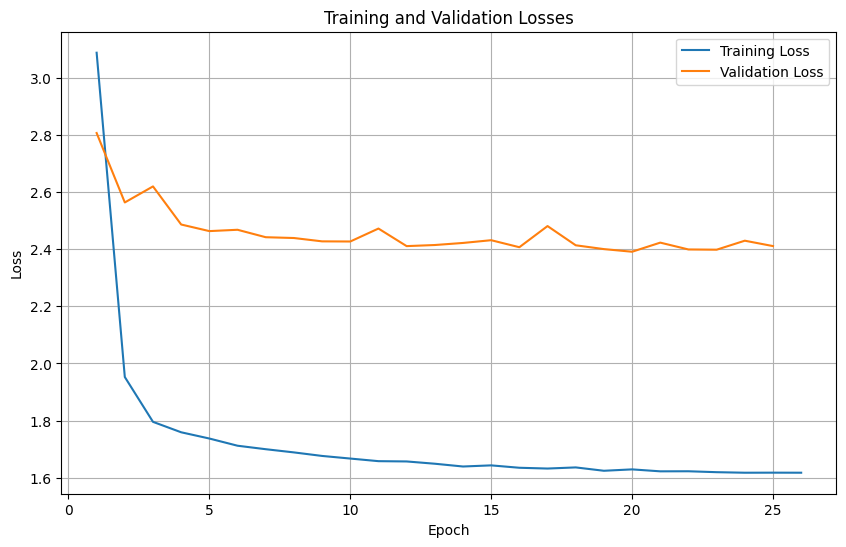


Training Summary:
Initial Training Loss: 3.0879
Final Training Loss: 1.6172
Best Training Loss: 1.6172

Initial Validation Loss: 2.8068
Final Validation Loss: 2.4108
Best Validation Loss: 2.3910


In [48]:

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

# Print final statistics
print("\nTraining Summary:")
print(f"Initial Training Loss: {train_losses[0]:.4f}")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print(f"Best Training Loss: {min(train_losses):.4f}")
print(f"\nInitial Validation Loss: {val_losses[0]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")
print(f"Best Validation Loss: {min(val_losses):.4f}")

## Evaluate the model

In [34]:
import torch

def evaluate_model(model, dataloader, device):
    """Evaluate the model and return predictions and labels for metric calculation."""
    model.eval()
    all_predictions = []
    all_labels = []

    print("\nEvaluating DataLoader...")
    total_samples = len(dataloader.dataset)
    print(f"Total samples in DataLoader: {total_samples}")

    with torch.no_grad():
        for batch_idx, (inputs, targets, impression_ids) in enumerate(dataloader):
            his_input_title, pred_input_title = inputs

            if batch_idx == 0:  # Debug first batch shapes
                print("\nFirst batch shapes:")
                print(f"  - his_input_title: {his_input_title.shape}")
                print(f"  - pred_input_title: {pred_input_title.shape}")
                print(f"  - targets: {targets.shape}")

            # Move data to device
            his_input_title = his_input_title.to(device)
            pred_input_title = pred_input_title.to(device)
            targets = targets.to(device)

            # Get predictions
            predictions = model.predict(his_input_title, pred_input_title)
            predictions = predictions.cpu().numpy()
            targets = targets.cpu().numpy()

            # Process each sample in the batch
            batch_size = predictions.shape[0]
            for sample_idx in range(batch_size):
                pred = predictions[sample_idx]
                label = targets[sample_idx]

                # Create valid_mask where label is not equal to the padding value (-1)
                valid_mask = (label != -1)
                sample_preds = pred[valid_mask]
                sample_labels = label[valid_mask]

                if len(sample_labels) == 0:
                    continue  # Skip empty samples

                # Ensure that there is at least one positive and one negative label
                if len(np.unique(sample_labels)) < 2:
                    continue  # Skip samples with only one class

                all_predictions.append(sample_preds.tolist())
                all_labels.append(sample_labels.tolist())

    print("\nEvaluation completed.")
    print(f"Total predictions generated: {len(all_predictions)}")
    print(f"First few prediction lengths: {[len(x) for x in all_predictions[:15]]}")
    return all_labels, all_predictions


# Evaluate the model
labels_list, scores_list = evaluate_model(model, val_dataloader_temp, device)

# Validate predictions against the DataFrame
print("\nValidation against DataFrame:")
if len(scores_list) != len(df_validation):
    print("WARNING: Length mismatch!")
    print(f"  - Number of predictions: {len(scores_list)}")
    print(f"  - Number of rows in DataFrame: {len(df_validation)}")

# Compute metrics
metrics = MetricEvaluator(
    labels=labels_list,
    predictions=scores_list,
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10)
    ],
)
results = metrics.evaluate()
print("\nMetrics:", results.evaluations)


Evaluating DataLoader...
Total samples in DataLoader: 48660

First batch shapes:
  - his_input_title: torch.Size([128, 40, 24])
  - pred_input_title: torch.Size([128, 91, 24])
  - targets: torch.Size([128, 91])

Evaluation completed.
Total predictions generated: 48660
First few prediction lengths: [7, 13, 9, 36, 10, 14, 5, 34, 7, 28, 10, 14, 9, 54, 7]

Validation against DataFrame:

Metrics: {'auc': 0.512731142492542, 'mrr': 0.3194453485969988, 'ndcg@5': 0.35434363795527135, 'ndcg@10': 0.4350932290431804}


In [35]:
print(f"FRACTION: {FRACTION}, HISTORY_SIZE: {HISTORY_SIZE}")

# Filter out special Python attributes and print parameters
params = {k: v for k, v in hparams_nrms.__dict__.items() if not k.startswith('__')}
print("Hyperparameters:")
for key, value in params.items():
    print(f"{key}: {value}")

FRACTION: 0.2, HISTORY_SIZE: 40
Hyperparameters:
title_size: 24
embedding_dim: 32
word_emb_dim: 8
vocab_size: 10000
head_num: 12
head_dim: 12
attention_hidden_dim: 128
hidden_dim: 4
optimizer: adam
loss: cross_entropy_loss
dropout: 0.2
learning_rate: 0.0001
weight_decay: 0.001
news_output_dim: 64
units_per_layer: [128, 128, 128]


In [49]:
def get_length_of_labels(df: pl.DataFrame, impression_id: int) -> int:
    # Filter for matching impression_id
    filtered = df.filter(pl.col('impression_id') == impression_id)
    
    if filtered.height == 0:
        raise ValueError(f"No row found for impression_id {impression_id}")
    
    # Get labels from first row
    labels = filtered.select('labels').row(0)[0]
    
    return len(labels)

In [37]:
# get_length_of_labels(df_validation, 349992000)

In [50]:
# Get first 5 labels
first_5_labels = df_validation.select('labels').head(5)

# Print each label with index
for i, row in enumerate(first_5_labels.iter_rows()):
    print(f"Label {i}: {row[0]}")

Label 0: [1, 0, 0, 0, 0, 0, 0]
Label 1: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Label 2: [0, 0, 0, 0, 0, 0, 0, 1, 0]
Label 3: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Label 4: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


In [51]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score

# Initialize lists
all_predictions = []
all_labels = []
skipped_samples = 0

model.eval()
with torch.no_grad():
    for (his_input_title, pred_input_title), targets, impression_ids in val_dataloader_temp:
        # Move to device
        his_input_title = his_input_title.to(device)
        pred_input_title = pred_input_title.to(device)
        
        # Get predictions
        predictions = model.predict(his_input_title, pred_input_title)
        
        
        # Convert to probabilities if needed
        if not torch.is_floating_point(predictions):
            predictions = torch.sigmoid(predictions)
        
        # Convert to lists while preserving structure
        batch_preds = predictions.cpu().numpy().tolist()
        batch_labels = targets.cpu().numpy().tolist()
        impression_ids = impression_ids.cpu().numpy().tolist()
        
        batch_preds_without_padding = []
        batch_labels_without_padding = []
        
        for pred_sample, label_sample, impression_id_sample in zip(batch_preds, batch_labels, impression_ids):
            # Remove padding
            actual_length = get_length_of_labels(df_validation, impression_id_sample)
            pred_sample = pred_sample[:actual_length]
            
            # Check if sample has both classes before adding
            if 1 in label_sample[:actual_length] and 0 in label_sample[:actual_length]:
                batch_preds_without_padding.append(pred_sample)
                batch_labels_without_padding.append(label_sample[:actual_length])
            else:
                skipped_samples += 1
        
        # Add batch predictions and labels
        all_predictions.extend(batch_preds_without_padding)
        all_labels.extend(batch_labels_without_padding)
print(f"Skipped {skipped_samples} samples with only one class")
print(f"Remaining valid samples: {len(all_predictions)}")

Skipped 0 samples with only one class
Remaining valid samples: 48660


In [40]:
# Debug: Print label distribution for first 5 samples
for i, (preds, labels) in enumerate(zip(all_predictions[:5], all_labels[:5])):
    print(f"\nSample {i}:")
    print(f"Labels length:      {len(labels)}")
    print(f"Predictions length: {len(preds)}")
    print(f"Num positives: {sum(labels)}")
    print(f"Num negatives: {len(labels) - sum(labels)}")
    print(f"Label distribution: {labels}")


Sample 0:
Labels length:      7
Predictions length: 7
Num positives: 1.0
Num negatives: 6.0
Label distribution: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Sample 1:
Labels length:      13
Predictions length: 13
Num positives: 1.0
Num negatives: 12.0
Label distribution: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Sample 2:
Labels length:      9
Predictions length: 9
Num positives: 1.0
Num negatives: 8.0
Label distribution: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]

Sample 3:
Labels length:      36
Predictions length: 36
Num positives: 1.0
Num negatives: 35.0
Label distribution: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Sample 4:
Labels length:      10
Predictions length: 10
Num positives: 1.0
Num negatives: 9.0
Label distribution: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


In [41]:
print(type(all_predictions))
print(type(all_labels))

print(f"Number of predictions: {len(all_predictions)}")
print(f"example prediction: {all_predictions[0:2]}")
print(f"Number of labels: {len(all_labels)}")
print(f"example label: {all_labels[0:2]}")




<class 'list'>
<class 'list'>
Number of predictions: 48660
example prediction: [[0.9999992847442627, 0.9999996423721313, 0.9999991655349731, 0.9999986886978149, 0.9999986886978149, 0.9999990463256836, 0.999998927116394], [0.9999990463256836, 0.9999992847442627, 0.9999991655349731, 0.999998927116394, 0.9999988079071045, 0.9999994039535522, 0.9999986886978149, 0.9999985694885254, 0.9999984502792358, 0.9999990463256836, 0.9999674558639526, 0.9999979734420776, 0.999998927116394]]
Number of labels: 48660
example label: [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


In [42]:
# Initialize counters
correct_predictions = 0
total_samples = len(all_predictions)

# Iterate over samples
for idx, _ in enumerate(all_predictions):
    # print(f"Sample {idx}: Prediction: {all_predictions[idx]}")
    # print(f"Sample {idx}: Label:      {all_labels[idx]}")
    
    # Extract index of maximum value in predictions and labels
    pred_max_index = np.argmax(all_predictions[idx])
    label_max_index = np.argmax(all_labels[idx])
    
    # Compare indices to determine if the prediction was correct
    if pred_max_index == label_max_index:
        # print(f"Sample {idx}: Prediction was correct.")
        correct_predictions += 1
  #  else:
        # print(f"Sample {idx}: Prediction was wrong.")

# Calculate accuracy
accuracy = correct_predictions / total_samples
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.1221


In [52]:
from evaluation import AucScore

# auc_score = AucScore()

# auc_score.calculate(all_predictions, all_labels)
# print(f"AUC: {auc_score.score}")
# # Calculate AUC per sample
aucs = []
for preds, labels in zip(all_predictions, all_labels):
    try:
        # Only calculate if we have both positive and negative samples
        if sum(labels) > 0 and sum(labels) < len(labels):
            auc = roc_auc_score(labels, preds)
            aucs.append(auc)
    except ValueError:
        raise ValueError("Only one class present in labels. Cannot calculate AUC.")

print(f"\nMean AUC: {np.mean(aucs):.4f}")
print(f"Number of valid AUC calculations: {len(aucs)}")


Mean AUC: 0.5217
Number of valid AUC calculations: 48660


## Output Prediction File

## References

https://github.com/recommenders-team/recommenders/blob/main/examples/00_quick_start/nrms_MIND.ipynb